In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima.arima as pm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm.notebook import tqdm

In [2]:
train = pd.read_csv("train.csv", index_col="Date")
train.index = pd.to_datetime(train.index)
train.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106


In [3]:
train.rename(
    columns = {
        "Weekly_Sales": "Sales",
        "Temperature": "Temp",
        "Fuel_Price": "Fuel",
        "Unemployment": "Unemp"
    },
    inplace = True
)
train.head()

,Store,Sales,Temp,Fuel,CPI,Unemp
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106


Данные разделяются по разным магазинам и приводятся к одинаковой частоте измерений.

In [4]:
def get_store(df, store):
    return df[df["Store"] == store].copy()

In [5]:
def split_by_store(df):
    stores = {}
    for i in range(1, 46):
        store = get_store(df, i)
        stores[i] = store.drop(columns="Store")
    return stores

In [6]:
stores_train = split_by_store(train)
stores_train[1]

,Sales,Temp,Fuel,CPI,Unemp
Date,,,,,
2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1409727.59,46.63,2.561,211.319643,8.106
...,...,...,...,...,...
2012-09-14,1517428.87,74.97,3.717,222.582019,6.908
2012-09-21,1506126.06,69.87,3.721,222.781839,6.908
2012-09-28,1437059.26,76.08,3.666,222.981658,6.908


In [7]:
def resample(stores):
    resampled = {}
    for i in range(1, 46):
        resampled[i] = stores[i].resample("W-Sun").mean().interpolate()
    return resampled

In [8]:
stores_train = resample(stores_train)
stores_train[1]

,Sales,Temp,Fuel,CPI,Unemp
Date,,,,,
2010-01-10,1.453330e+06,71.890,2.60300,211.671989,7.838000
2010-01-17,1.475920e+06,71.815,2.62575,211.509490,7.827875
2010-01-24,1.498511e+06,71.740,2.64850,211.346991,7.817750
2010-01-31,1.521102e+06,71.665,2.67125,211.184491,7.807625
2010-02-07,1.543693e+06,71.590,2.69400,211.021992,7.797500
...,...,...,...,...,...
2012-09-16,1.517429e+06,74.970,3.71700,222.582019,6.908000
2012-09-23,1.506126e+06,69.870,3.72100,222.781839,6.908000
2012-09-30,1.437059e+06,76.080,3.66600,222.981658,6.908000


In [9]:
stores_train[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2010-01-10 to 2012-10-14
Freq: W-SUN
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   145 non-null    float64
 1   Temp    145 non-null    float64
 2   Fuel    145 non-null    float64
 3   CPI     145 non-null    float64
 4   Unemp   145 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


In [10]:
def feature_over_time(stores, feature, store = None):
    fig, ax = plt.subplots(figsize=(20, 9))
    if  isinstance(store, int):
        ax.plot(stores[store].index, stores[store][feature])
        ax.legend([f"Store {store}"])
    else:
        store = store if store else list(range(1, 46))
        legend = []
        for i in store:
            ax.plot(stores[i].index, stores[i][feature])
            legend.append(f"Store {i}")
        ax.legend(legend, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=9)

    ax.set(title=f"{feature} over Time", xlabel="Date", ylabel=feature)
    ax.grid()

    plt.show()

In [11]:
# feature_over_time(stores_train, "Sales", store=[])

Из графиков продаж в магазинах можно заметить годовую сезонность. Максимум продаж в каждом году по датам совпадает с новогодними праздниками и черной пятницей

In [12]:
def ts_plot(y, lags=13, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, method='ywmle', lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        plt.show()
    return 

In [13]:
# ts_plot(stores_train[1]["Sales"], lags=10)

Нужно обработать дополнительные признаки.

In [14]:
stores_train[1].head()

,Sales,Temp,Fuel,CPI,Unemp
Date,,,,,
2010-01-10,1.453330e+06,71.890,2.60300,211.671989,7.838000
2010-01-17,1.475920e+06,71.815,2.62575,211.509490,7.827875
2010-01-24,1.498511e+06,71.740,2.64850,211.346991,7.817750
2010-01-31,1.521102e+06,71.665,2.67125,211.184491,7.807625
2010-02-07,1.543693e+06,71.590,2.69400,211.021992,7.797500


In [15]:
# feature_over_time(stores_train, feature="Temp")

Погода также имеет годовую сезонность

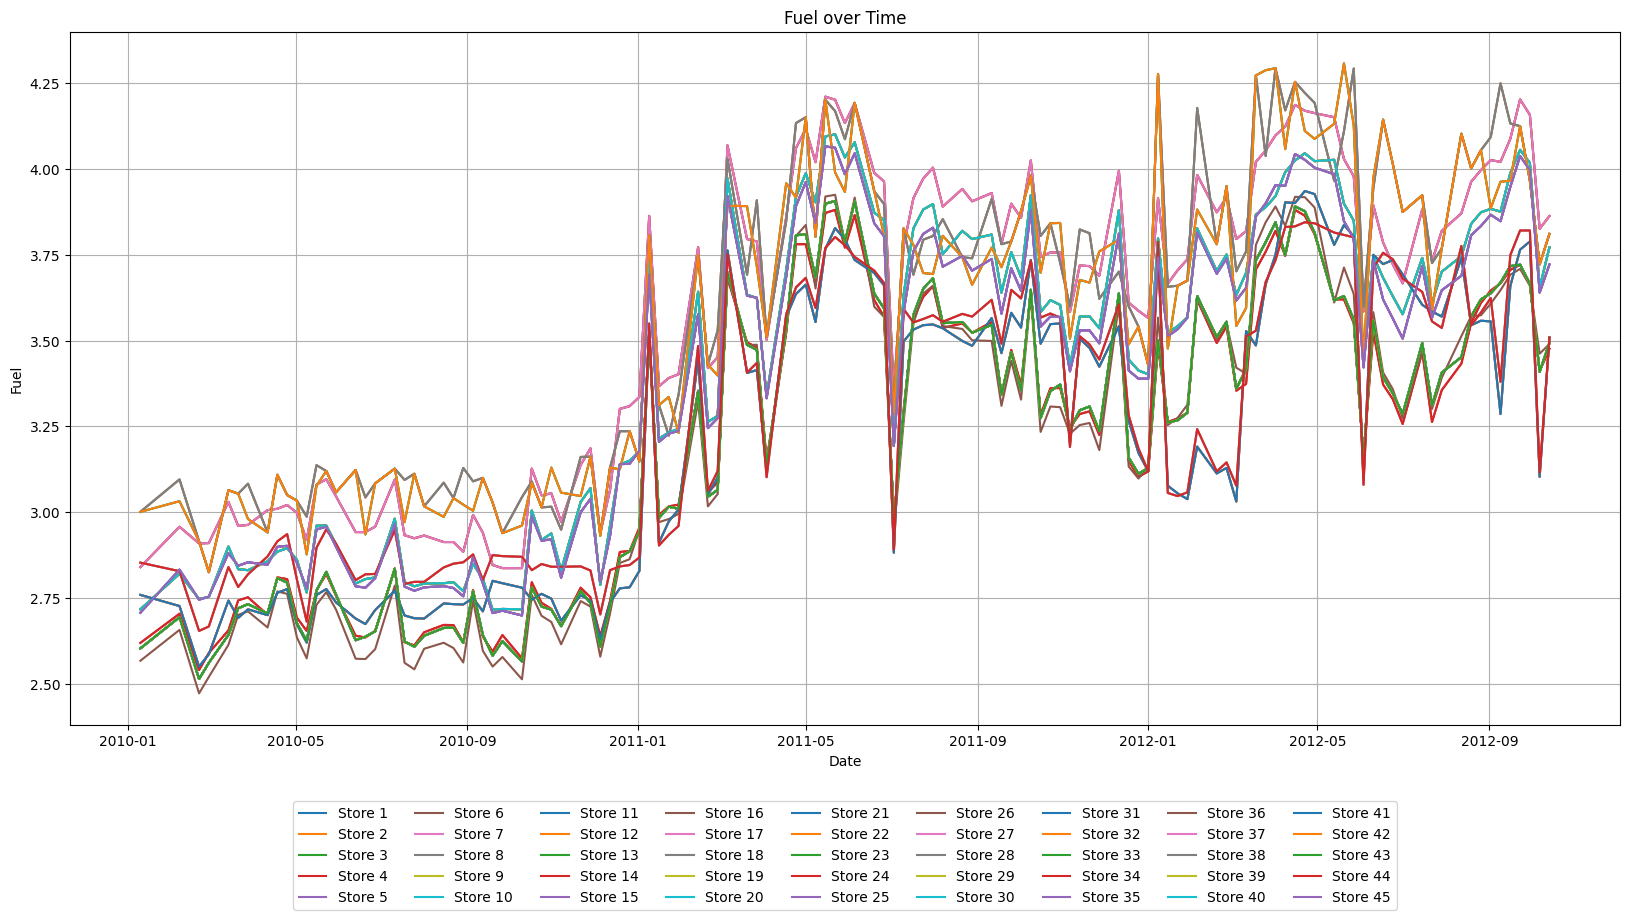

In [16]:
feature_over_time(stores_train, feature="Fuel")

На этом графике видно, что в конце 2010 года сильно изменился характер ряда.

In [17]:
# feature_over_time(stores_train, feature="CPI")

In [18]:
# feature_over_time(stores_train, feature="Unemp")

Из всех признаков необходимо убрать влияние тренда, а также отделить сезонность от шума.

In [19]:
def process_exog(df):
    res = pd.DataFrame()
    for feature in df:
        result = smt.ExponentialSmoothing(
            df[feature], 
            trend="add", 
            damped_trend=True, 
            seasonal='add', 
            seasonal_periods=52, 
            use_boxcox=False
        ).fit(use_brute=True)
        
        res[f"{feature}_seasonal"] = result.season
        res[f"{feature}_resid"] = result.resid
        
    scaler = StandardScaler()
    res = pd.DataFrame(scaler.fit_transform(res), columns=scaler.feature_names_in_, index=df.index)
    return res

In [20]:
# stores_exog = {}
# for i in range(1, 46):
#     store = stores_train[i]
#     stores_exog[i] = process_exog(store.drop(columns="Sales"))

# stores_exog[1].describe()

In [21]:
# feature_over_time(stores_exog, feature="Temp_resid")

In [22]:
def estimate(y, exog):
    y_train, y_test = y.iloc[:-9], y.iloc[-9:]
    exog_train, exog_test = exog.iloc[:-9], exog.iloc[-9:]
    model = pm.auto_arima(
        y_train,
        X = exog_train,
        m = 52,
        n_jobs = 1,
        scoring = 'mae',
        error_action = 'ignore'
    )
    y_pred = model.predict(9, X=exog_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

In [23]:
# %%time
# mape_scores = []
# for i in tqdm(range(1, 46)):
#     y = stores_train[i]["Sales"]
#     exog = stores_exog[i]
#     mape = estimate(y, exog)
#     mape_scores.append(mape)

In [24]:
# np.mean(mape_scores)

In [25]:
test = pd.read_csv("test.csv", index_col="Date")
test.index = pd.to_datetime(test.index)
test.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,
2012-10-19,1,67.97,3.594,223.425723,6.573
2012-10-26,1,69.16,3.506,223.444251,6.573
2012-11-05,1,73.77,3.688,221.725663,7.143
2012-12-10,1,62.99,3.601,223.381296,6.573
2012-10-19,2,68.08,3.594,223.059808,6.170


In [26]:
test.rename(
    columns = {
        "Weekly_Sales": "Sales",
        "Temperature": "Temp",
        "Fuel_Price": "Fuel",
        "Unemployment": "Unemp"
    },
    inplace = True
)
test.head()

,Store,Temp,Fuel,CPI,Unemp
Date,,,,,
2012-10-19,1,67.97,3.594,223.425723,6.573
2012-10-26,1,69.16,3.506,223.444251,6.573
2012-11-05,1,73.77,3.688,221.725663,7.143
2012-12-10,1,62.99,3.601,223.381296,6.573
2012-10-19,2,68.08,3.594,223.059808,6.170


In [27]:
stores_test = split_by_store(test)
stores_test[1]

,Temp,Fuel,CPI,Unemp
Date,,,,
2012-10-19,67.97,3.594,223.425723,6.573
2012-10-26,69.16,3.506,223.444251,6.573
2012-11-05,73.77,3.688,221.725663,7.143
2012-12-10,62.99,3.601,223.381296,6.573


In [28]:
stores_test = resample(stores_test)
stores_test[1]

,Temp,Fuel,CPI,Unemp
Date,,,,
2012-10-21,67.970,3.5940,223.425723,6.573
2012-10-28,69.160,3.5060,223.444251,6.573
2012-11-04,71.465,3.5970,222.584957,6.858
2012-11-11,73.770,3.6880,221.725663,7.143
2012-11-18,71.614,3.6706,222.056790,7.029
2012-11-25,69.458,3.6532,222.387917,6.915
2012-12-02,67.302,3.6358,222.719043,6.801
2012-12-09,65.146,3.6184,223.050170,6.687
2012-12-16,62.990,3.6010,223.381296,6.573


Из предсказания надо будет взять 1, 2, 4 и 9 строки, так как они соответствуют исходным значениям.

In [29]:
stores_exog = {}
for i in range(1, 46):
    store = pd.concat((stores_train[i].drop(columns="Sales"), stores_test[i]))
    stores_exog[i] = process_exog(store)

stores_exog[1].describe()

,Temp_resid,Fuel_resid,CPI_resid,Unemp_resid
count,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02
mean,-1.730218e-17,1.153478e-17,-1.730218e-17,-1.153478e-17
std,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00
min,-2.754395e+00,-3.487436e+00,-3.594613e+00,-3.122300e+00
25%,-4.626321e-01,-4.284246e-01,-4.694774e-01,-4.974624e-01
50%,2.609329e-02,-6.647287e-02,-1.354780e-02,-1.845519e-02
75%,5.742908e-01,4.873136e-01,5.163648e-01,4.924823e-01
max,2.838329e+00,3.607558e+00,3.736063e+00,3.017004e+00


In [30]:
def predict(y, exog):
    exog_train, exog_test = exog.iloc[:-9], exog.iloc[-9:]
    model = pm.auto_arima(
        y,
        X = exog_train,
        m = 52,
        n_jobs = 1,
        scoring = 'mae',
        error_action = 'ignore'
    )
    y_pred = model.predict(9, X=exog_test)
    return y_pred.iloc[[0, 1, 3, 8]]

In [31]:
%%time
predicts = np.array([])
for i in tqdm(range(1, 46)):
    y = stores_train[i]["Sales"]
    exog = stores_exog[i]
    y_pred = predict(y, exog)
    predicts = np.concatenate((predicts, y_pred))

  0%|          | 0/45 [00:00<?, ?it/s]

CPU times: user 22h 32min 11s, sys: 1min 41s, total: 22h 33min 53s
Wall time: 1h 53min 15s


In [33]:
predicts.shape

(180,)

In [34]:
submission = pd.DataFrame({"Weekly_Sales": predicts})
submission.head()

,Weekly_Sales
0,1.607577e+06
1,1.556405e+06
2,1.579052e+06
3,1.748043e+06
4,1.768114e+06


In [ ]:
submission.to_csv("submission.csv", index_label="ID")